In [1]:
import matplotlib.pyplot as plt, numpy as np, pandas as pd, noise, seaborn as sns
from skimage.morphology import (disk, ball)
from skimage.filters import threshold_isodata, roberts

In [2]:
# COMMENT THIS OUT IF SETTING RADIUS ABOVE 5
# pd.set_option('display.max_columns', None)

In [3]:
# Set Radius of island and island seed
seed = 27
r = 5
d = (r*2)

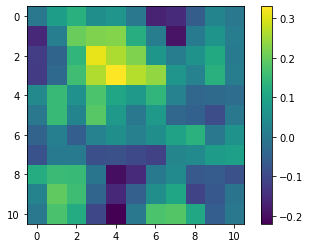

In [4]:
# Code copied from https://medium.com/@yvanscher/playing-with-perlin-noise-generating-realistic-archipelagos-b59f004d8401 to generate perlin using Noise module
shape = (d+1,d+1)
scale = r
octaves = 6
persistence = 0.5
lacunarity = 2.0

world = np.zeros(shape)
for i in range(shape[0]):
    for j in range(shape[1]):
        world[i][j] = noise.pnoise2(i/scale, 
                                    j/scale, 
                                    octaves=octaves, 
                                    persistence=persistence, 
                                    lacunarity=lacunarity, 
                                    repeatx=1024, 
                                    repeaty=1024, 
                                    base=seed)
        
plt.imshow(world)
plt.colorbar();

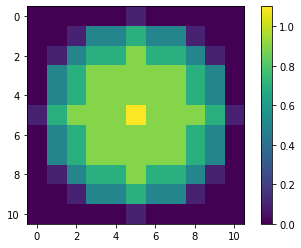

In [5]:
# Generate ball, flatten to 2d array
bosco = ball(r)
biscotti = np.sum(bosco, axis=1)/(d)
plt.imshow(biscotti)
plt.colorbar();

In [6]:
# Truncation (commented out, we don't love the effect)
#for i in range(len(biscotti)):
#    for j in range(len(biscotti)):
#        if biscotti[i][j] > 0.6:
#            biscotti[i][j] = 0.6

#plt.imshow(biscotti)
#plt.colorbar();

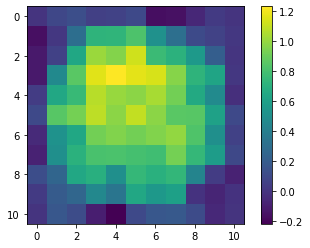

In [7]:
# Combine world and dome to create textured dome
biscuit_land = world+biscotti
plt.imshow(biscuit_land)
plt.colorbar();

In [8]:
# Set/display inundation level based on median altitude
flood = np.median(biscuit_land)
flood

0.5049776169471443

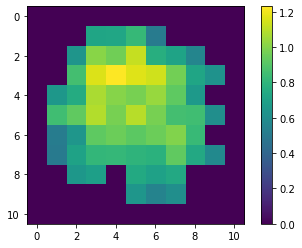

In [9]:
# Determine inundated area
dunked_biscuit = np.zeros((d+1,d+1))
for i in range(len(biscuit_land)):
    for j in range(len(biscuit_land)):
        if biscuit_land[i][j] < flood:
            dunked_biscuit[i][j] = 0
        else:
            dunked_biscuit[i][j] = biscuit_land[i][j]

plt.imshow(dunked_biscuit)
plt.colorbar();

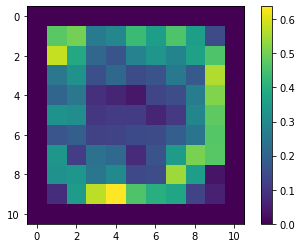

In [10]:
# Roberts edge detection to determine slopes, this will be used later
croissant = roberts(biscuit_land)
            
plt.imshow(croissant)
plt.colorbar();

In [11]:
pancakes = []
for i in range(len(biscuit_land)):
    for j in range(len(biscuit_land)):
        pancake = {'y': i, 'x': j, 'z': biscuit_land[i][j]}
        pancakes.append(pancake)

In [12]:
df = pd.DataFrame(pancakes)

In [13]:
df = df.sort_values('z', ascending=False)

In [14]:
df['flooded'] = True

In [15]:
df.loc[df.z > flood, 'flooded'] = False

In [16]:
df['volume'] = 0.1

In [17]:
df['edge'] = False

In [18]:
df.loc[df.x == 0, 'edge'] = True

In [19]:
df.loc[df.x == d, 'edge'] = True

In [20]:
df.loc[df.y == 0, 'edge'] = True

In [21]:
df.loc[df.y == d, 'edge'] = True

In [22]:
df.loc[df['edge'] == False]

,y,x,z,flooded,volume,edge
37,3,4,1.230579,False,0.1,False
38,3,5,1.170011,False,0.1,False
36,3,3,1.165033,False,0.1,False
39,3,6,1.141477,False,0.1,False
27,2,5,1.124414,False,0.1,False
...,...,...,...,...,...,...
23,2,1,0.058589,True,0.1,False
97,8,9,0.039416,True,0.1,False
12,1,1,0.016523,True,0.1,False
107,9,8,-0.006960,True,0.1,False


In [23]:
def find_pointer(row):
#    if not row['edge']:
    y = row['y']
    x = row['x']
    return df.loc[(df['y'] <= y+1) & (df['y'] >= y-1) & (df['x'] <= x+1) & (df['x'] >= x-1)].tail(1).index[0]

In [24]:
df['pointer'] = df.apply(find_pointer, axis=1)

In [39]:
df['pond'] = False

In [40]:
df

,y,x,z,flooded,volume,edge,pointer,pond
37,3,4,1.230579,False,0.1,False,26,False
38,3,5,1.170011,False,0.1,False,28,False
36,3,3,1.165033,False,0.1,False,24,False
39,3,6,1.141477,False,0.1,False,29,False
27,2,5,1.124414,False,0.1,False,17,False
...,...,...,...,...,...,...,...,...
33,3,0,-0.121295,True,0.6,True,33,False
7,0,7,-0.154043,True,0.4,True,6,False
11,1,0,-0.157588,True,0.7,True,11,False
6,0,6,-0.168001,True,1.0,True,6,False


In [44]:
def flood_time(row):
    if row['pointer'] != row.name:
        df.loc[row['pointer'], 'volume'] += row['volume']

In [45]:
df.apply(flood_time, axis=1);

In [46]:
df.sort_values("volume", ascending=False)

,y,x,z,flooded,volume,edge,pointer,pond
114,10,4,-0.219756,True,2.0,True,114,False
6,0,6,-0.168001,True,2.0,True,6,False
54,4,10,-0.022016,True,2.0,True,54,False
77,7,0,-0.080266,True,2.0,True,77,False
98,8,10,-0.083781,True,1.8,True,98,False
...,...,...,...,...,...,...,...,...
35,3,2,0.862123,False,0.1,False,23,False
5,0,5,0.100000,True,0.1,True,6,False
90,8,2,0.650872,False,0.1,False,100,False
65,5,10,0.100000,True,0.1,True,54,False


In [29]:
cookie = np.zeros((d+1, d+1))

In [30]:
def back_to_np(row):
    x = row['x']
    y = row['y']
    cookie[y][x] = row['volume']

In [31]:
df.apply(back_to_np, axis=1);

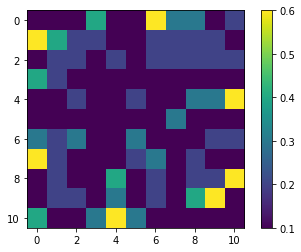

In [32]:
plt.imshow(cookie)
plt.colorbar();